# Basic Nighttime Lights Raster Processing


You can get these data packages via the ['sez' tag at the SDRDL Data Repository](https://data.sandiegodata.org/?s=sez)

In [1]:
import seaborn as sns
import metapack as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rowgenerators as rg
import fiona
import rasterio
import rasterio.mask
from IPython.display import display 
from rasterio.plot import reshape_as_raster, reshape_as_image, show
from tqdm.notebook import tqdm
from requests import get  # to make GET request
import boto3
import h5py 

%matplotlib inline
sns.set_context('notebook')


In [2]:
# Open the two main data packages
sez_p = mp.open_package('http://library.metatab.org/worldbank.org-sez-1.1.1.csv')

# Displaying the package shows metadata
sez_p

# Special economic zones
`worldbank.org-sez-1.1.1` Last Update: 2021-07-12T20:47:42

_Information on special economic zones have been individually collected and researched in a study focusing on the governance of SEZ. This is just a subset (586) of the extant global SEZs, which have been estimated at 3500-4000._


## Documentation Links

* [Documentation Page](http://library.metatab.org/worldbank.org-sez-1.1.1/index.html) 
* [Dataset webpage](https://datacatalog.worldbank.org/dataset/special-economic-zones-sez) 
* [Dataset viewer web application](http://devseed.com/sez-viewer/#/BGD6) 

 

## Contacts

* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)

## Resources

* ** [sez](http://library.metatab.org/worldbank.org-sez-1.1.1/data/sez.csv)**. Special Economic Zones

In [3]:
#sez_p.resource('sez')

In [4]:

# Create Dataframes
sez = sez_p.resource('sez').geoframe()

# Update the SEZ geometries to be a 20KM buffer around the point. We project to 
# EPSG:3395, World Mercator, to be able to make the buffer in meters. 
g =  sez.to_crs(3395).buffer(20_000)

sez['geo_area'] = g.area
sez['geometry'] = g.to_crs(4326)

# The operational date col is a string, so make an int year column. 
sez['year'] = pd.to_numeric(sez.operational_date, errors='coerce')

In [5]:
# Test the file upload

# Download the file
def download(radius):
    """Download patches file, radius in Km"""
    dl_fn = f'patches_{radius}k.h5'
    with open(dl_fn, "wb") as file:
        # get request
        response = get(f'http://public.source.civicknowledge.com.s3.amazonaws.com/sez/sez_circ_patches_{radius}000.h5')
        # write to file
        file.write(response.content)

    return dl_fn
        
# Get a random selection of patches from the file
def get_hdf_keys(f):
    """Return all of the dataset keys in an HDF5 file"""
    keys = []
    f.visit(lambda key : keys.append(key) if isinstance(f[key], h5py.Dataset) else None)
    return keys


    
dl_fn = download(10)
dl_fn

'patches_10k.h5'

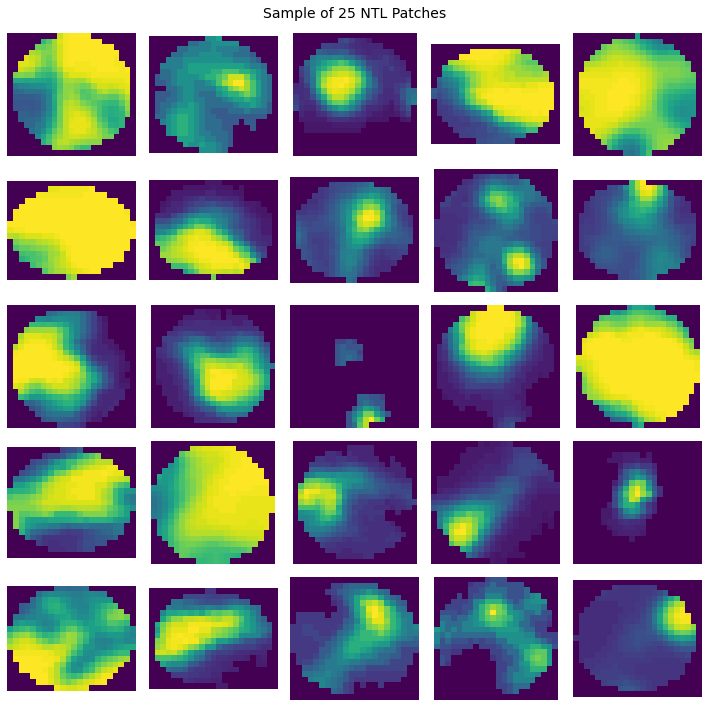

In [6]:
# Plot a random sample
from random import shuffle

with h5py.File(dl_fn, 'r') as f:
    keys = get_hdf_keys(f)

shuffle(keys)

fig, axes = plt.subplots(5,5, figsize=(10,10))
axes = np.ravel(axes)

with h5py.File(dl_fn, 'r') as f:
    for k, a in zip(keys[:len(axes)], axes):
        r = f[k][:]
        a.set_axis_off()
        show(r, ax=a)

fig.suptitle('Sample of 25 NTL Patches', fontsize=14)
plt.tight_layout()

In [33]:
# For each of the patches in the HDF5 file, sum up all of the pixel values. 
with h5py.File(dl_fn, 'r') as f:
    
    keys = get_hdf_keys(f)
    rasters = []
    for k in keys:
        _, sez_id, year = k.split('/')
        rasters.append( (int(year), sez_id, np.nansum(f[k][:])))
        
t = pd.DataFrame(rasters, columns=['year', 'unique_id', 'pixel_sum'])   

t = t.merge(sez.rename(columns={'year':'op_year'}), on='unique_id')
t['mean_light'] = t.pixel_sum / t.geo_area

# Unit Norm
t_ = t.mean_light-t.mean_light.min()
t['mean_light_un'] = (t_/t_.max())

# Get the smallest value for mean_light, to avoid errors with log()
#dt=t['mean_light'].dtype.type
#t['mean_light'] = t['mean_light'].replace(0, np.nextafter(dt(0), dt(1))) # Next after will return the smallest value above zero

t['mean_light'] = t['mean_light'].replace(0, np.nan)

ml = t[t.op_year > 1996] # so we are certain to have a few years of light data before
g = ml.groupby('unique_id')


In [8]:
def split_series(df):
    bf = df[df.year<=df.op_year].sort_values('year').reset_index(drop=True)
    af = df[df.year>=df.op_year].sort_values('year').reset_index(drop=True)

    
    return bf, af


def exp_line_fit(x,y=None):
    
    from numpy.linalg import LinAlgError 
    
    if y is None:
        df = x
        x = df['year']
        y = df['mean_light']
    
    y = np.log(y)
    
    try:
        fit = np.polyfit(x,y,1)
    
    except LinAlgError:
        # Didn't converge
        return [np.nan,np.nan]
    except ValueError:
        # Something Else
        return [np.nan,np.nan]
    
        
    beta, alpha = np.exp(fit)
    
    return beta-1, alpha



def compute_yoy(df):
    
    bf, af = split_series(df)
    
    def _f(t):
        ml = t.mean_light
        return (ml.iloc[-1]-ml.iloc[0])/len(ml)
        
    return pd.Series([_f(bf), _f(af)])

def compute_slopes(df):

    bf, af = split_series(df)
    
    return pd.Series([exp_line_fit(bf)[0], exp_line_fit(af)[0]])

_ = g.apply(exp_line_fit) # Check that it works. 

t = g.get_group('BGD11')
bf, af = split_series(t)
compute_slopes(t)

0    0.010037
1    0.078817
dtype: float64

(4.795831523312719, 4.0)

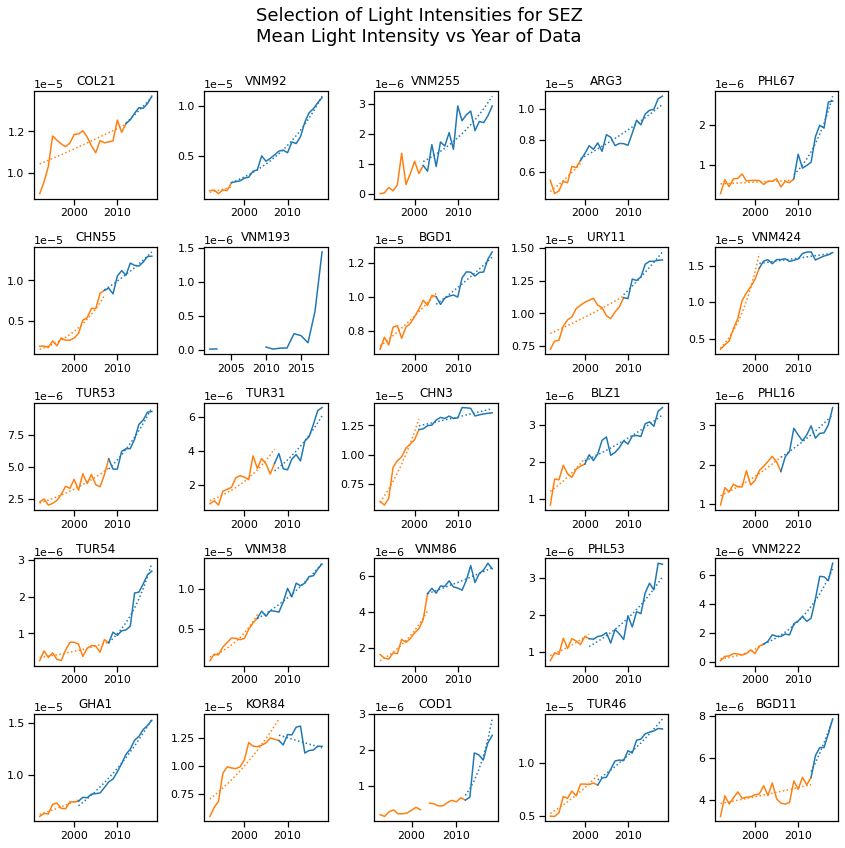

In [35]:
from random import choice

def fit_line(x, y=None):
    r, x0 = exp_line_fit(x, y)
    y_ = x0*(r+1)**x
    return y_
    

def plot_sez_ts(df, title=''):
    
    g = df.groupby('unique_id')
    
    size = int(min(np.floor(np.sqrt(len(g))), 5))
    
    fig, axes = plt.subplots(size,size, figsize=(12,12))
    for ax in np.ravel(axes): 

        uid = choice(list(g.groups.keys()))
        ex_series = g.get_group(uid)
        bf, af = split_series(ex_series)

        a1 = ax.plot(bf.year, bf.mean_light, color='tab:orange')
        y_ = fit_line(bf.year, bf.mean_light)
        ax.plot(bf.year, y_, color='tab:orange', linestyle=':')

        ax.plot(af.year, af.mean_light, color='tab:blue')
        y_ = fit_line(af.year, af.mean_light)
        ax.plot(af.year, y_, color='tab:blue', linestyle=':')

        ax.set_title(uid)

    fig.suptitle(f"Selection of Light Intensities for SEZ\nMean Light Intensity vs Year of Data\n{title}", fontsize=18)
    plt.tight_layout()
    
plot_sez_ts(ml)

The plot above is a random selection of 25 SEZ, showing the light intensity over time ( solid line ). Where the line is orange is the time before the SEZ become active, and the blue ortion is after. The dotted lines are a line fit to the log of the light intensity, so the slope of the fit is the growth rate of the light intensity, assuming a model of exponential growth. ( Which is why some of the dotted lines are curved. ) 

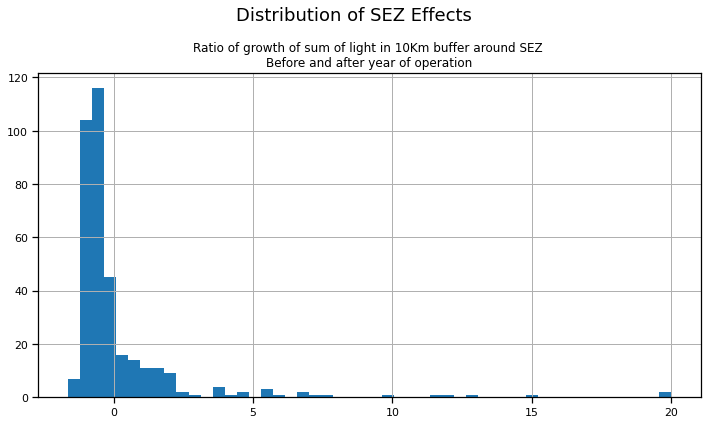

In [38]:
slopes = g.apply(compute_slopes).rename(columns={0:'pre_slope',1:'post_slope'}).reset_index()
slopes['rate_change'] = (slopes.post_slope - slopes.pre_slope)/np.abs(slopes.pre_slope)
slopes['rate_change'] = slopes['rate_change'].clip(-10,20)

# plt.xscale('symlog')
slopes.rate_change.hist(bins = 50, figsize=(10, 6))

plt.suptitle('Distribution of SEZ Effects', fontsize=18)
plt.title('Ratio of growth of sum of light in 10Km buffer around SEZ \nBefore and after year of operation')
plt.tight_layout()

In [41]:
df = sez.merge(slopes[['unique_id','rate_change']])
df.head().T

,0,1,2,3,4
id,175,176,177,178,179
unique_id,ARG1,ARG2,COL4,DOM60,DOM28
check,ARG,ARG,COL,DOM,DOM
latitude,-34.850398,-33.836551,3.562428,19.479942,19.409734
longitude,-57.904152,-65.182394,-76.450645,-70.632936,-70.66086
...,...,...,...,...,...
note,NaN,NaN,NaN,NaN,NaN
geometry,POLYGON ((-57.7244889431761 -34.85039799999966...,POLYGON ((-65.00273094317609 -33.8365509999996...,POLYGON ((-76.27098194317608 3.562427999999697...,POLYGON ((-70.45327294317609 19.47994199999912...,"POLYGON ((-70.48119694317609 19.4097339999991,..."
geo_area,1254619396.218367,1254619396.218367,1254619396.21837,1254619396.218367,1254619396.218367
year,1997.0,1997.0,1997.0,1997.0,1997.0


In [43]:
t = df.groupby('country').rate_change.mean().sort_values(ascending=False).dropna()
display(t.head())
display(t.tail())

country
Sudan         11.815522
Russia         5.252995
Uruguay        4.514143
Pakistan       2.364061
Bangladesh     2.053074
Name: rate_change, dtype: float64

country
Dominican Republic   -0.792938
Madagascar           -0.807367
Fiji                 -0.870795
Angola               -0.883641
Sri Lanka            -1.062834
Name: rate_change, dtype: float64

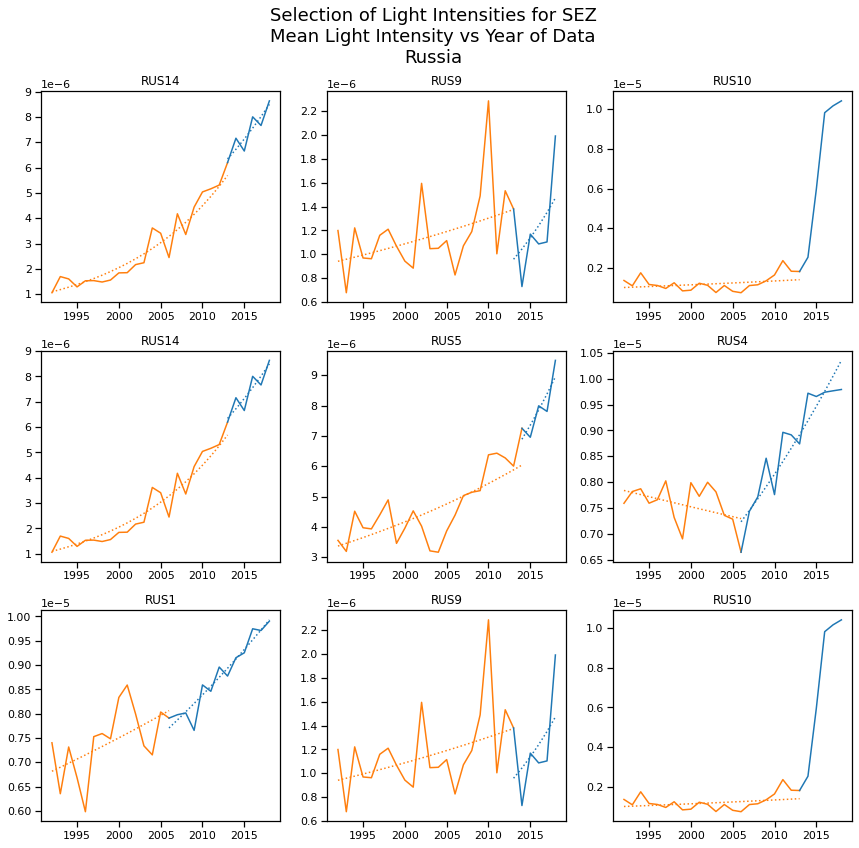

In [45]:
plot_sez_ts(ml[ml.country=='Russia'], title='Russia')

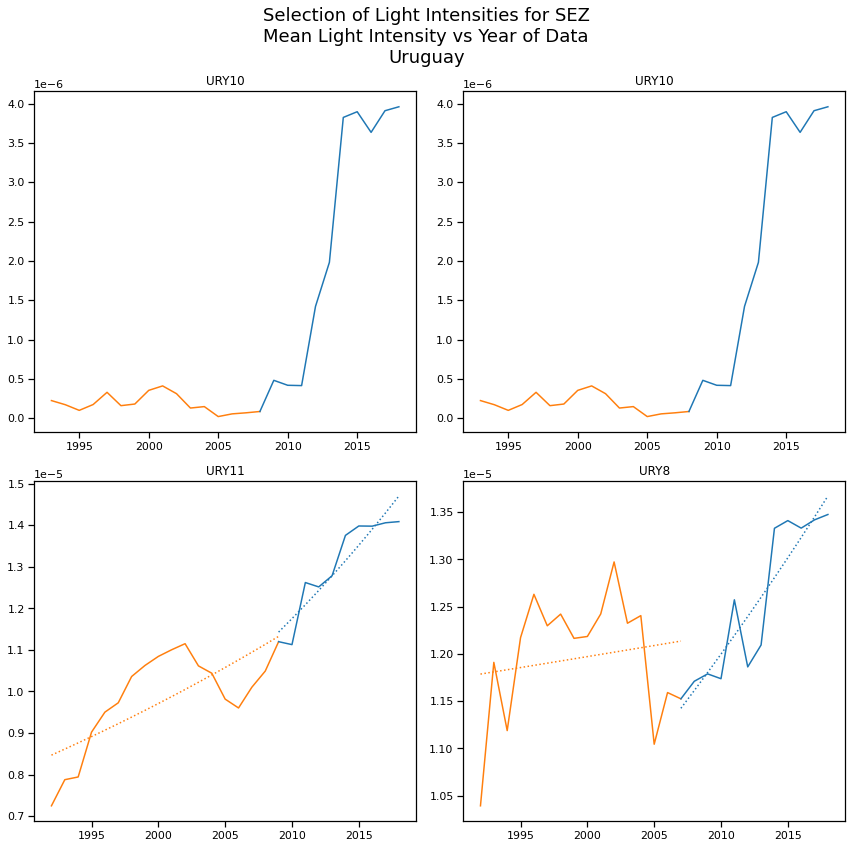

In [46]:
plot_sez_ts(ml[ml.country=='Uruguay'], title='Uruguay')

In [14]:
df.groupby('region').rate_change.mean().sort_values(ascending=False).dropna()


region
ECA     1.041929
LAC     0.986957
SA      0.610011
SSA    -0.340245
EAP    -0.516852
MENA   -0.644228
Name: rate_change, dtype: float64

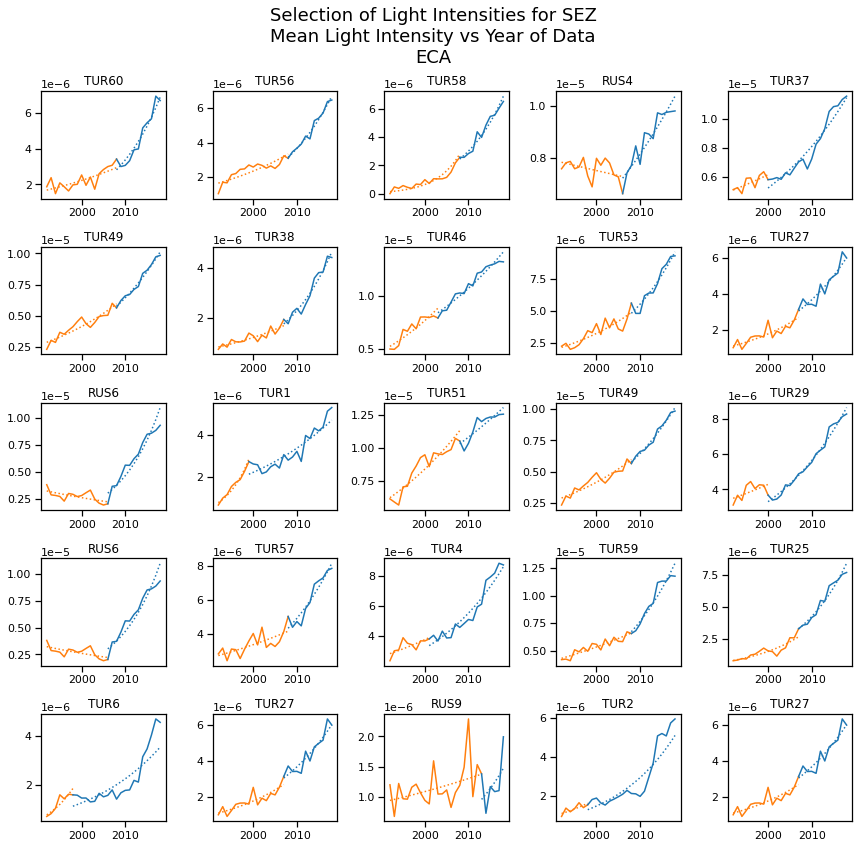

In [48]:
plot_sez_ts(ml[ml.region=='ECA'], title='ECA')

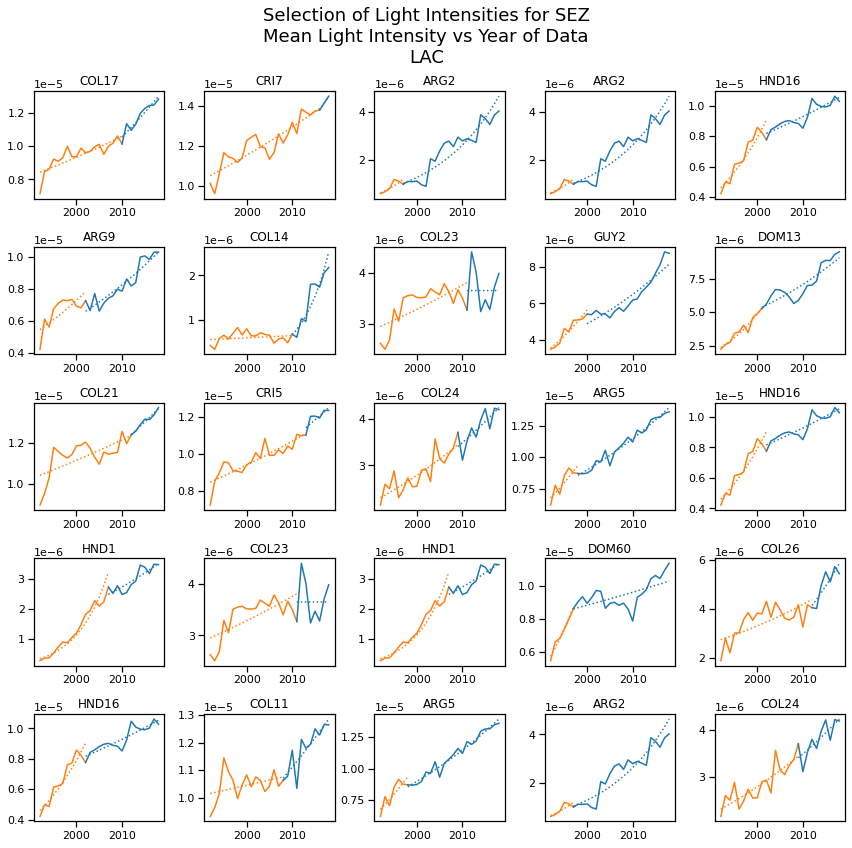

In [50]:
plot_sez_ts(ml[ml.region=='LAC'], title='LAC')

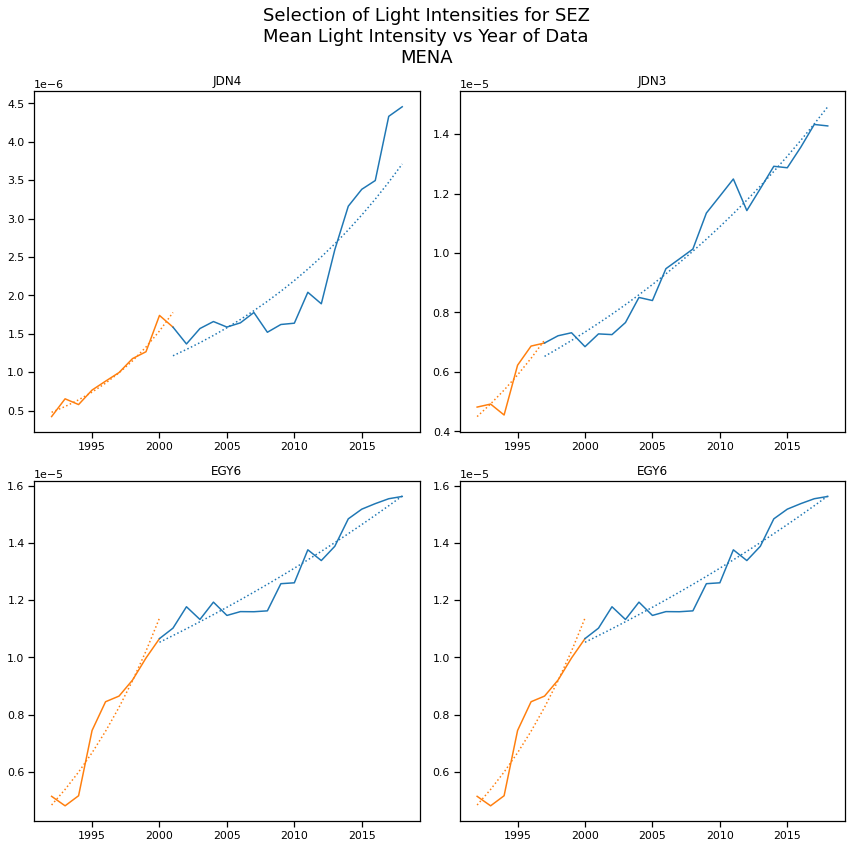

In [49]:
plot_sez_ts(ml[ml.region=='MENA'], title='MENA')

In [16]:
df.groupby('management_type').rate_change.mean().sort_values(ascending=False).dropna()

management_type
PPP                       0.368183
Private management        0.149322
State-owned enterprise   -0.033698
Public agency            -0.339226
Name: rate_change, dtype: float64

In [17]:
df.groupby('authority_independence').rate_change.mean().sort_values(ascending=False).dropna()

authority_independence
Yes    0.234697
No    -0.067963
Name: rate_change, dtype: float64

In [18]:
df.groupby('size_range').rate_change.mean().sort_values(ascending=False).dropna()

size_range
Less than 30 ha          0.493765
300 to 999 ha            0.486688
30 to 99 ha             -0.060873
100 to 299 ha           -0.139613
Greater than 5,000 ha   -0.326463
1,000 to 4,999 ha       -1.170910
Name: rate_change, dtype: float64

In [19]:
df.groupby('authority_independence').rate_change.mean().sort_values(ascending=False).dropna()

authority_independence
Yes    0.234697
No    -0.067963
Name: rate_change, dtype: float64

In [20]:
len(df)

386

In [21]:
df

,id,unique_id,check,latitude,longitude,country_code,country_type_combo,region,country,zone_type,...,city_500k,city_500kdist,500kcity_range,city_300k,city_300kdist,note,geometry,geo_area,year,rate_change
0,175,ARG1,ARG,-34.850398,-57.904152,ARG,ARGFree Trade Zone,LAC,Argentina,Free Trade Zone,...,La Plata,11,Less than 50 km,La Plata,11,NaN,"POLYGON ((-57.72449 -34.85040, -57.72535 -34.8...",1.254619e+09,1997.0,7.282162
1,176,ARG2,ARG,-33.836551,-65.182394,ARG,ARGFree Trade Zone,LAC,Argentina,Free Trade Zone,...,Cordoba,337,300 to 999 km,Cordoba,337,NaN,"POLYGON ((-65.00273 -33.83655, -65.00360 -33.8...",1.254619e+09,1997.0,-0.432131
2,177,COL4,COL,3.562428,-76.450645,COL,COLFree Industrial Zone,LAC,Colombia,Free Industrial Zone,...,Cali,18,Less than 50 km,Cali,18,NaN,"POLYGON ((-76.27098 3.56243, -76.27185 3.54473...",1.254619e+09,1997.0,-0.883246
3,178,DOM60,DOM,19.479942,-70.632936,DOM,DOMFree Zone,LAC,Dominican Republic,Free Zone,...,Santiago de los Caballeros,11,Less than 50 km,Santiago de los Caballeros,11,NaN,"POLYGON ((-70.45327 19.47994, -70.45414 19.463...",1.254619e+09,1997.0,-0.902361
4,179,DOM28,DOM,19.409734,-70.660860,DOM,DOMFree Zone,LAC,Dominican Republic,Free Zone,...,Santiago de los Caballeros,14,Less than 50 km,Santiago de los Caballeros,14,NaN,"POLYGON ((-70.48120 19.40973, -70.48206 19.393...",1.254619e+09,1997.0,-0.897144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,556,KOR14,KOR,35.208063,128.671840,KOR,KORIndustrial Complex,EAP,Korea,Industrial Complex,...,Changwon,3,Less than 50 km,Changwon,3,NaN,"POLYGON ((128.85150 35.20806, 128.85064 35.193...",1.254619e+09,2015.0,-1.082989
382,557,RUS12,RUS,46.689415,47.852942,RUS,RUSSpecial Economic Zone,ECA,Russia,Special Economic Zone,...,Astrakhan,43,Less than 50 km,Astrakhan,43,NaN,"POLYGON ((48.03261 46.68941, 48.03174 46.67730...",1.254619e+09,2015.0,4.837833
383,558,ZWE1,ZWE,-17.873272,31.200952,ZWE,ZWESpecial Economic Zone,SSA,Zimbabwe,Special Economic Zone,...,Harare,19,Less than 50 km,Harare,19,The Government has designated Sunway City to b...,"POLYGON ((31.38062 -17.87327, 31.37975 -17.890...",1.254619e+09,2015.0,1.794288
384,559,CRI7,CRI,9.995793,-84.249379,CRI,CRIFree Zone,LAC,Costa Rica,Free Zone,...,No city in country with population greater tha...,0,Less than 50 km,San Jose,20,NaN,"POLYGON ((-84.06972 9.99579, -84.07058 9.97834...",1.254619e+09,2016.0,1.134202
